# Pengerjaan Tugas Deep Learning menggunakan TensorFlow (Week 7, Dataset ReviewTokoBaju)

File ini memuat pelatihan model Bidirectional RNN dan Deep RNN, masing-masing menggunakan TensorFlow, untuk dataset ReviewTokoBaju.csv

# Persiapan: Instalasi library dan Data Preprocessing

### 1. Memastikan Instalasi library

In [43]:
# !pip install numpy matplotlib scikit-learn torch tensorflow tensorflow-datasets
# %pip install numpy matplotlib scikit-learn torch tensorflow[] nltk 

### 2. Mengimpor Library yang Dibutuhkan

In [44]:
# Import library yang diperlukan
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.layers import SimpleRNN, Bidirectional, GRU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import json
import re
import string
import time
from copy import deepcopy

# Memeriksa apakah GPU tersedia dan dapat digunakan oleh TensorFlow
gpu_available = tf.test.is_gpu_available()
print(f"GPU available: {gpu_available}")


GPU available: True


I0000 00:00:1745168473.224157  106653 gpu_device.cc:2019] Created device /device:GPU:0 with 1877 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


### 3. Mendefinisikan Parameter dan Pre-processing Dataset

Dataset shape: (23486, 11)
   Unnamed: 0  Clothing ID  Age                    Title  \
0           0          767   33                      NaN   
1           1         1080   34                      NaN   
2           2         1077   60  Some major design flaws   
3           3         1049   50         My favorite buy!   
4           4          847   47         Flattering shirt   

                                         Review Text  Rating  Recommended IND  \
0  Absolutely wonderful - silky and sexy and comf...       4                1   
1  Love this dress!  it's sooo pretty.  i happene...       5                1   
2  I had such high hopes for this dress and reall...       3                0   
3  I love, love, love this jumpsuit. it's fun, fl...       5                1   
4  This shirt is very flattering to all due to th...       5                1   

   Positive Feedback Count   Division Name Department Name Class Name  
0                        0       Initmates        Int

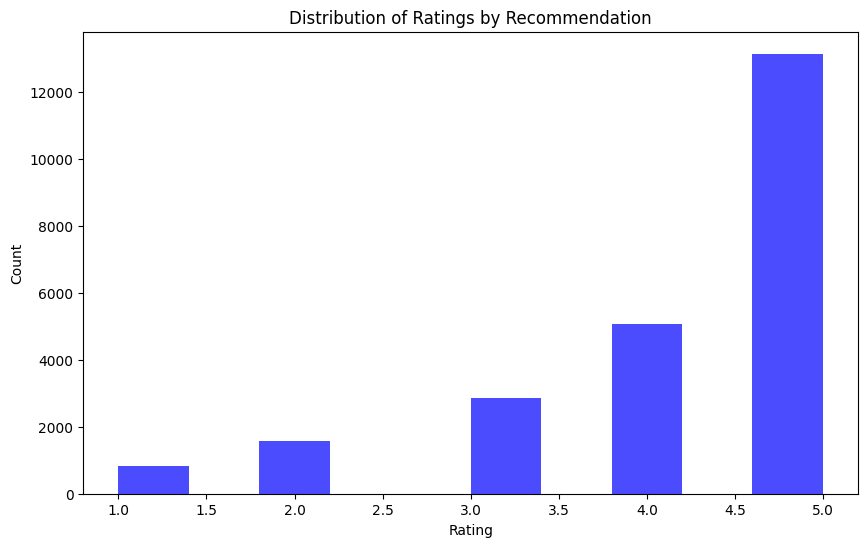

Found 15395 unique tokens
Shape of X_train: (18788, 100)
Shape of X_test: (4698, 100)


In [ ]:
# Konstanta dan parameter
NUM_WORDS = 40000
MAXLEN = 100
BATCH_SIZE = 64
EMBEDDING_DIM = 128
HIDDEN_DIM = 128
DROPOUT_RATE = 0.4
EPOCHS = 20

# Baca dataset
df = pd.read_csv('../ReviewTokoBaju.csv')

# Data Exploration
print(f"Dataset shape: {df.shape}")
print(df.head())
print(df.info())

# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Fill missing values in 'Review Text' and 'Title'
df['Review Text'] = df['Review Text'].fillna('')
df['Title'] = df['Title'].fillna('')

# Combine Title and Review Text for better features
df['Combined_Text'] = df['Title'] + ' ' + df['Review Text']

# Target variable: 'Recommended IND' (0 or 1)
print("\nDistribution of Recommended IND:")
print(df['Recommended IND'].value_counts())

# Check correlation between Rating and Recommended IND
print("\nCorrelation between Rating and Recommended IND:")
print(df[['Rating', 'Recommended IND']].corr())

# Plot distribution of ratings
plt.figure(figsize=(10, 6))
plt.hist(df['Rating'], bins=10, color='blue', alpha=0.7)
plt.title('Distribution of Ratings by Recommendation')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# TensorFlow tokenizer
tokenizer = Tokenizer(num_words=NUM_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(df['Combined_Text'])
sequences = tokenizer.texts_to_sequences(df['Combined_Text'])
word_index = tokenizer.word_index
print(f'Found {len(word_index)} unique tokens')

X = pad_sequences(sequences, maxlen=MAXLEN, padding='post', truncating='post')
y = df['Recommended IND'].values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of X_test: {X_test.shape}')

train_data = (X_train, y_train)
test_data = (X_test, y_test)

### 4. Menyiapkan Fungsi Pelatihan dan Validasi

In [46]:
# Fungsi untuk melatih model TensorFlow
def train_model_tf(model, train_data, model_name):
    x_train, y_train = train_data
    
    # Callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        ModelCheckpoint(
            filepath=f'model_tensorflow_{model_name}.keras',
            monitor='val_loss',
            save_best_only=True
        )
    ]
    
    print(f"Memulai pelatihan model {model_name}...")
    start_time = time.time()
    
    # Melatih model
    history = model.fit(
        x_train, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.2,
        shuffle=True,
        callbacks=callbacks,
        verbose=1
    )
    
    end_time = time.time()
    training_time = end_time - start_time
    mins, secs = divmod(training_time, 60)
    print(f"Waktu pelatihan: {int(mins)}m {int(secs)}s")
    
    return history

### 5. Menyiapkan Fungsi Evaluasi

In [47]:
# Fungsi untuk evaluasi model TensorFlow
def evaluate_model_tf(model, test_data, model_name):
    x_test, y_test = test_data
    
    # Prediksi
    y_pred_prob = model.predict(x_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    
    # Menghitung metrik evaluasi
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_prob)
    
    # Menghitung ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    
    # Print hasil evaluasi
    print(f"\nEvaluasi Model {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'fpr': fpr,
        'tpr': tpr,
        'y_pred_prob': y_pred_prob,
        'y_pred': y_pred,
        'y_test': y_test
    }

### 6. Menyiapkan Fungsi Visualisasi

In [48]:
# Fungsi untuk membuat visualisasi hasil
# Fungsi untuk membuat visualisasi training history
def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 5))
    
    best_epoch = history['val_loss'].index(min(history['val_loss']))
    best_val_loss = min(history['val_loss'])

    # Plot Loss, dengan tanda pada titik terbaik
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Valid Loss')
    plt.axvline(x=best_epoch, color='r', linestyle='--', label='Best Model')
    plt.axhline(y=best_val_loss, color='g', linestyle='--', label='Best Val Loss')
    plt.title(f'{model_name} - Loss History')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Valid Accuracy')
    plt.axvline(x=best_epoch, color='r', linestyle='--', label='Best Model')
    plt.axhline(y=history['val_accuracy'][best_epoch], color='g', linestyle='--', label='Val Accuracy at Best Model')
    plt.title(f'{model_name} - Accuracy History')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'training_history_tensorflow_{model_name}.png')
    plt.show()

# Fungsi untuk membuat confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Negative', 'Positive'])
    plt.yticks(tick_marks, ['Negative', 'Positive'])
    
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_tensorflow_{model_name}.png')
    plt.show()

# Fungsi untuk membuat ROC curve
def plot_roc_curve(results_dict):
    plt.figure(figsize=(10, 8))
    
    for model_name, result in results_dict.items():
        plt.plot(result['fpr'], result['tpr'], label=f'{model_name} (AUC = {result["auc"]:.4f})')
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend()
    plt.grid(True)
    plt.savefig('roc_curve_comparison_tensorflow.png')
    plt.show()

# Fungsi untuk membuat bar chart perbandingan metrik
def plot_metrics_comparison(results_dict):
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']
    models = list(results_dict.keys())
    
    values = {metric: [results_dict[model][metric] for model in models] for metric in metrics}
    
    plt.figure(figsize=(12, 8))
    bar_width = 0.15
    index = np.arange(len(models))
    
    for i, metric in enumerate(metrics):
        plt.bar(index + i * bar_width, values[metric], bar_width, 
                label=metric.capitalize())
    
    plt.xlabel('Models')
    plt.ylabel('Scores')
    plt.title('Performance Metrics Comparison')
    plt.xticks(index + bar_width * 2, models)
    plt.legend()
    plt.grid(True, axis='y')
    plt.savefig('metrics_comparison_tensorflow.png')
    plt.show()


## A. Model Bidirectional RNN Menggunakan TensorFlow

### 1. Menyusun Model Bidirectional RNN


In [49]:
# Fungsi untuk membuat model RNN kompleks
def build_birnn_model():
    model = Sequential([
        Input(shape=(MAXLEN,)),
        Embedding(NUM_WORDS, EMBEDDING_DIM),
        
        Bidirectional(SimpleRNN(HIDDEN_DIM, return_sequences=True)),
        BatchNormalization(),
        Dropout(DROPOUT_RATE),
        Bidirectional(SimpleRNN(HIDDEN_DIM, return_sequences=False)),
        BatchNormalization(),
        Dropout(DROPOUT_RATE),
        
        Dense(HIDDEN_DIM // 2, activation='relu'),
        Dropout(DROPOUT_RATE),
        Dense(1, activation='sigmoid')
    ])
    
    return model

# inisialisasi model
model_birnn = build_birnn_model()

### 2. Melatih Model

In [50]:
# Menyusun model
model_birnn.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy', metrics=['accuracy'])

# Melatih model RNN
print("Melatih model RNN...")
history_birnn = train_model_tf(model_birnn, (X_train, y_train), 'birnn')

Melatih model RNN...
Memulai pelatihan model birnn...
Epoch 1/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 26s 93ms/step - accuracy: 0.5114 - loss: 0.9864 - val_accuracy: 0.8201 - val_loss: 0.5730
Epoch 2/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 18s 76ms/step - accuracy: 0.6860 - loss: 0.6825 - val_accuracy: 0.8201 - val_loss: 0.5916
Epoch 3/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 18s 78ms/step - accuracy: 0.7578 - loss: 0.5729 - val_accuracy: 0.8191 - val_loss: 0.4902
Epoch 4/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 18s 77ms/step - accuracy: 0.7637 - loss: 0.5536 - val_accuracy: 0.8228 - val_loss: 0.5152
Epoch 5/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 19s 82ms/step - accuracy: 0.8017 - loss: 0.4710 - val_accuracy: 0.8358 - val_loss: 0.5312
Epoch 6/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 18s 77ms/step - accuracy: 0.8336 - loss: 0.3967 - val_accuracy: 0.7813 - val_loss: 0.4303
Epoch 7/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 18s 78ms/step - accuracy: 0.8580 - loss: 0.3429 - val_accuracy: 0.8361 - val_loss: 0.3621
Epoch 8/20
235/235 ━━━━━━━━━━━━━━━━━

### 3. Mengevaluasi Model dengan Menghitung Akurasi, Presisi, Recall, F1Squared, ROC, dan AUC-ROC

In [51]:
# Evaluasi model RNN
result_birnn = evaluate_model_tf(model_birnn, test_data, 'birnn')

147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step

Evaluasi Model birnn:
Accuracy: 0.8829
Precision: 0.9426
Recall: 0.9127
F1 Score: 0.9274
AUC: 0.9196


### 4. Memvisualisasikan Prediksi dari model yang telah dilatih

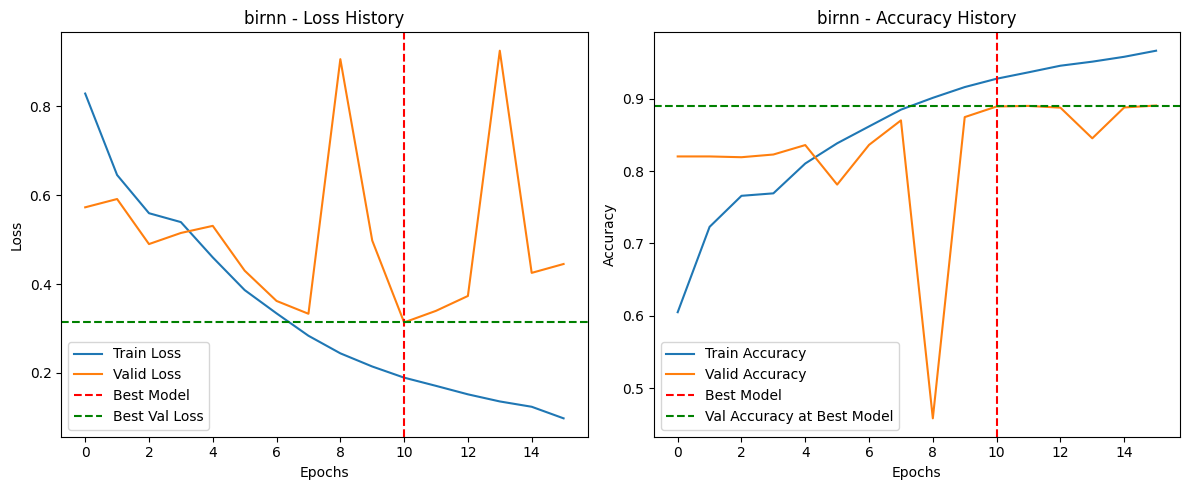

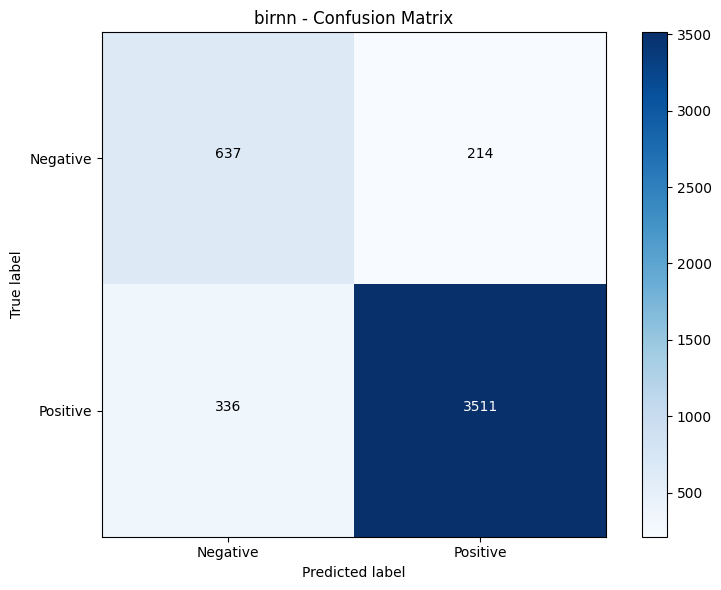

In [52]:
# Plotting hasil pelatihan
plot_training_history(history_birnn.history, "birnn")

# Plotting confusion matrix
plot_confusion_matrix(y_test, result_birnn['y_pred'], "birnn")

### 5. Menyimpan Model

In [53]:
# Menyimpan model
model_birnn.save('model_tensorflow_birnn.keras')
print("Model RNN disimpan sebagai 'model_tensorflow_birnn.keras'")

Model RNN disimpan sebagai 'model_tensorflow_birnn.keras'


## B. Model Deep RNN Menggunakan TensorFlow

### 1. Menyusun Model Deep RNN


In [54]:
# Fungsi untuk membuat model RNN kompleks
def build_drnn_model():
    model = Sequential([
        Input(shape=(MAXLEN,)),
        Embedding(NUM_WORDS, EMBEDDING_DIM),
        
        SimpleRNN(HIDDEN_DIM, return_sequences=True),
        BatchNormalization(),
        Dropout(DROPOUT_RATE),
        SimpleRNN(HIDDEN_DIM, return_sequences=True),
        BatchNormalization(),
        Dropout(DROPOUT_RATE),
        SimpleRNN(HIDDEN_DIM, return_sequences=True),
        BatchNormalization(),
        Dropout(DROPOUT_RATE),
        SimpleRNN(HIDDEN_DIM, return_sequences=True),
        BatchNormalization(),
        Dropout(DROPOUT_RATE),
        SimpleRNN(HIDDEN_DIM, return_sequences=False),
        BatchNormalization(),
        Dropout(DROPOUT_RATE),
        
        Dense(HIDDEN_DIM, activation='relu'),
        Dropout(DROPOUT_RATE),
        Dense(HIDDEN_DIM // 2, activation='relu'),
        Dropout(DROPOUT_RATE),
        Dense(HIDDEN_DIM // 4, activation='relu'),
        Dropout(DROPOUT_RATE),
        Dense(1, activation='sigmoid')
    ])
    
    return model

# inisialisasi model
model_drnn = build_birnn_model()

### 2. Melatih Model

In [55]:
# Menyusun model
model_drnn.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy', metrics=['accuracy'])

# Melatih model RNN
print("Melatih model RNN...")
history_drnn = train_model_tf(model_drnn, (X_train, y_train), 'drnn')

Melatih model RNN...
Memulai pelatihan model drnn...
Epoch 1/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 26s 93ms/step - accuracy: 0.5754 - loss: 0.8769 - val_accuracy: 0.8185 - val_loss: 0.4867
Epoch 2/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 17s 74ms/step - accuracy: 0.7177 - loss: 0.6637 - val_accuracy: 0.8199 - val_loss: 0.5267
Epoch 3/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 17s 73ms/step - accuracy: 0.7384 - loss: 0.5945 - val_accuracy: 0.8199 - val_loss: 0.4879
Epoch 4/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 17s 73ms/step - accuracy: 0.7818 - loss: 0.5344 - val_accuracy: 0.8220 - val_loss: 0.4219
Epoch 5/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 17s 72ms/step - accuracy: 0.7941 - loss: 0.4988 - val_accuracy: 0.8199 - val_loss: 0.7213
Epoch 6/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 17s 73ms/step - accuracy: 0.8151 - loss: 0.4463 - val_accuracy: 0.8584 - val_loss: 0.3199
Epoch 7/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 17s 71ms/step - accuracy: 0.8466 - loss: 0.3618 - val_accuracy: 0.8113 - val_loss: 0.3889
Epoch 8/20
235/235 ━━━━━━━━━━━━━━━━━━

### 3. Mengevaluasi Model dengan Menghitung Akurasi, Presisi, Recall, F1Squared, ROC, dan AUC-ROC

In [56]:
# Evaluasi model RNN
result_drnn = evaluate_model_tf(model_drnn, test_data, 'drnn')

147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step

Evaluasi Model drnn:
Accuracy: 0.8861
Precision: 0.9169
Recall: 0.9467
F1 Score: 0.9316
AUC: 0.9229


### 4. Memvisualisasikan Prediksi dari model yang telah dilatih

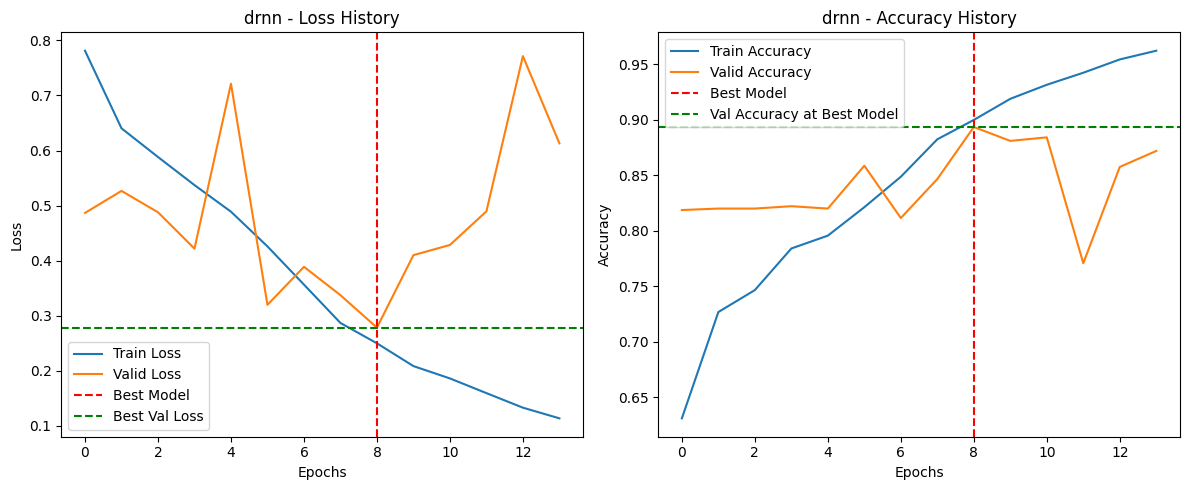

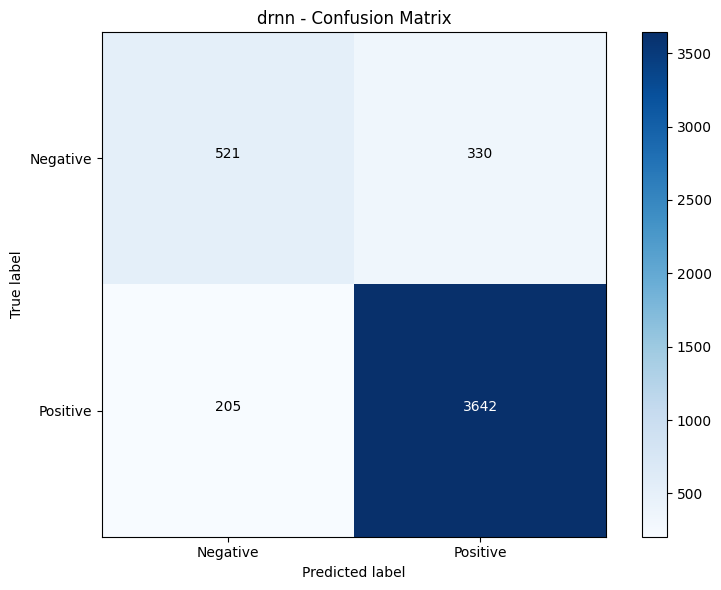

In [57]:
# Plotting hasil pelatihan
plot_training_history(history_drnn.history, "drnn")

# Plotting confusion matrix
plot_confusion_matrix(y_test, result_drnn['y_pred'], "drnn")

### 5. Menyimpan Model

In [58]:
# Menyimpan model
model_birnn.save('model_tensorflow_drnn.keras')
print("Model RNN disimpan sebagai 'model_tensorflow_drnn.keras'")

Model RNN disimpan sebagai 'model_tensorflow_drnn.keras'


# Perbandingan antara model

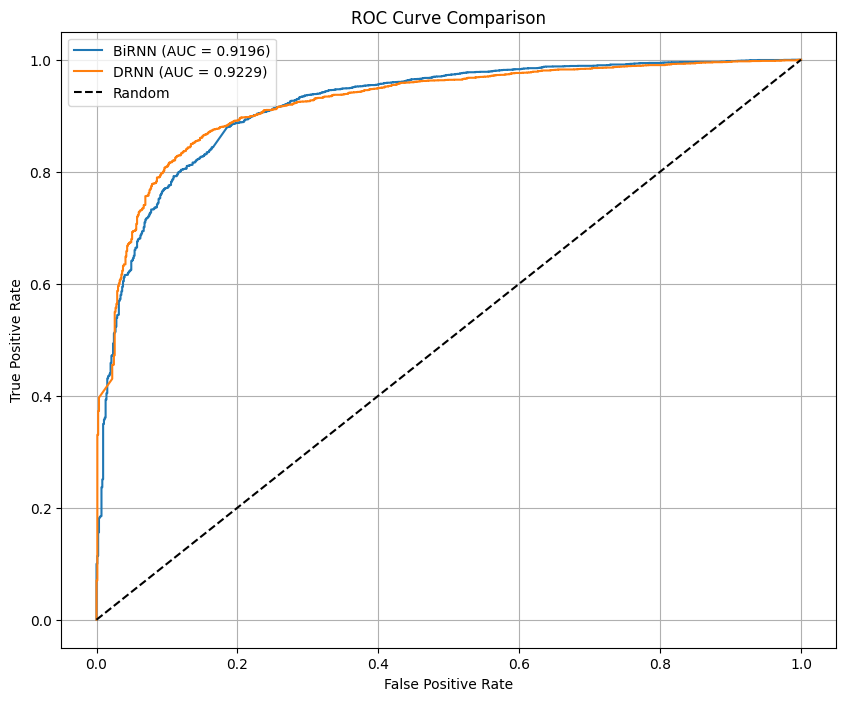

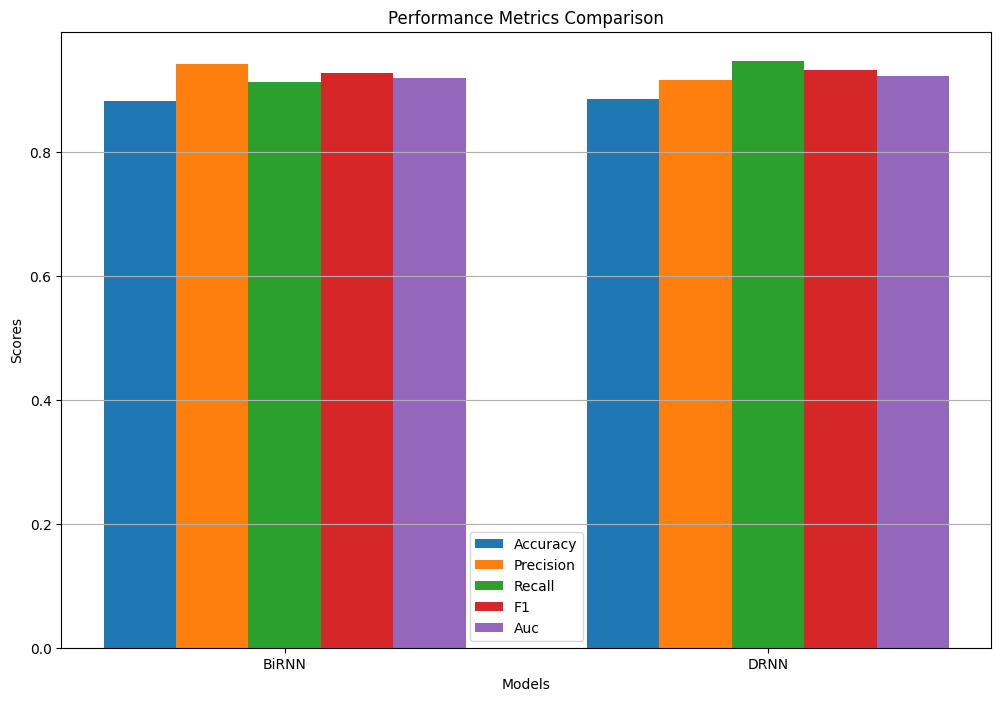

In [59]:
# Menghitung perbandingan untuk semua model
results_dict = {
    'BiRNN': result_birnn,
    'DRNN': result_drnn,
}

# Plotting ROC curve
plot_roc_curve(results_dict)
# Plotting perbandingan metrik
plot_metrics_comparison(results_dict)